# FIX - Cholecystectomy Notebook

FIX is built using the `exlib` library, which we load using a local version for now. You can uncomment the `!pip install exlib` line and comment out the `import sys; sys.path.insert(0, "../../src")` line if you do not have a local version you are testing.

In [1]:
# Uncomment line below to install exlib
# !pip install exlib
import sys; sys.path.insert(0, "../../src")
import exlib

In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from exlib.datasets.cholec import *
from exlib.features.vision import *

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview
* The objective is to predict the **go/nogo** regions (safe, unsafe).
* The higher-level features are the **organs** (liver, gallblader, and hepatocystic triangle).

## Load datasets and pre-trained models

In [3]:
dataset = CholecDataset(split="test")

## Dataset samples
Primary task: predict the safe/unsafe regions

In [4]:
sample = dataset[7] # Lucky number
image, gonogo, organs = sample["image"], sample["gonogo"], sample["organs"]

<Figure size 640x480 with 0 Axes>

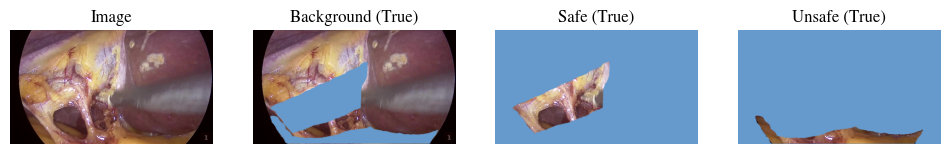

In [5]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "gng_t0", "gng_t1", "gng_t2"],
], figsize=(12,4))

for _, a in ax.items(): a.set_axis_off()
gng_titles = ["Background", "Safe", "Unsafe"]
C1 = torch.tensor([0.4, 0.6, 0.8]).view(3,1,1)
C2 = torch.tensor([0.6, 0.8, 0.4]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(3):
    mask_t = (gonogo == i).unsqueeze(0)
    ax[f"gng_t{i}"].imshow(((image * mask_t) + (~mask_t * C1)).numpy().transpose(1,2,0))
    ax[f"gng_t{i}"].set_title(f"{gng_titles[i]} (True)")


## Expert-specified higher-level features: organs
Identifying key anatomical structures is an important step for surgeons

<Figure size 640x480 with 0 Axes>

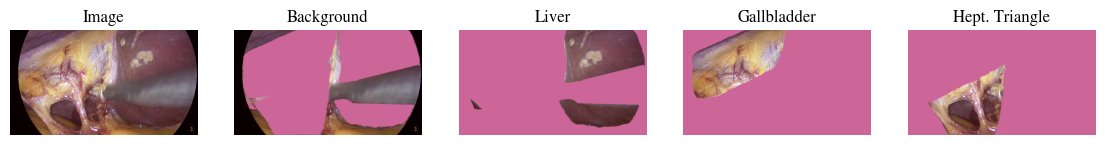

In [6]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "org_t0", "org_t1", "org_t2", "org_t3"],
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
org_titles = ["Background", "Liver", "Gallbladder", "Hept. Triangle"]
C3 = torch.tensor([0.8, 0.4, 0.6]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(4):
    mask_t = (organs == i).unsqueeze(0)
    ax[f"org_t{i}"].imshow(((image * mask_t) + (~mask_t * C3)).numpy().transpose(1,2,0))
    ax[f"org_t{i}"].set_title(f"{org_titles[i]}")

## How well are the higher-level feature alignments?

In [7]:
all_baseline_scores = get_cholec_scores(num_todo=100, batch_size=8)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [11:16<00:00, 52.03s/it]


In [8]:
for name, scores in all_baseline_scores.items():
    print(f'BASELINE {name} mean score: {scores.mean()}')

BASELINE identity mean score: 0.46502915024757385
BASELINE random mean score: 0.10826199501752853
BASELINE patch mean score: 0.03222788870334625
BASELINE quickshift mean score: 0.26145440340042114
BASELINE watershed mean score: 0.2729993462562561
BASELINE sam mean score: 0.3647386133670807
BASELINE ace mean score: 0.2841452360153198
BASELINE craft mean score: 0.029236257076263428
BASELINE archipelago mean score: 0.3421355187892914
